## IST 707 DATA ANALYTICS HOMEWORK 4

## STASTISTICAL LEARNING, DEEP LEARNING AND A COMPLETE COMPARISON

### Submitted by YESWANTH REDDY VELAPALEM on 26th April 2020

### EXECUTIVE SUMMARY :
*This report provides analysis and evaluation of several classification techniques that are used to solve a binary classification which helps in predicting whether or not a patient has a certain unspecified disease. Methods of building a good classification model include identifying the data quality issues, finding the data patterns, building a base model and tuning the required hyperparameters to improve the performance of the model.*

*In this assignment, Classification models are built using training data and perform extenisve hyperparameter tuning and in turn used to make predictions on test data to produce good Accuracy, Recall, Precision and AUCROC scores. The goal is to produce unbiased and low variance estimates. Comparisons are made between various models to see if they have similar performances.*

### INTRODUCTION :
*Health complications are the no.1 cause of death in the world. The best approcah to reduce the death rate is early detection of the disease. In this assignment we will implement models including Logistic Regression, Decision Tree and Neural Networks to predict the probability of a patient having a disease based on results from medical tests such as blood pressure values and Cholesterol, Glucose etc.*

In [1]:
import warnings
warnings.filterwarnings('ignore')

**Importing required libraries**

In [2]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score

In [3]:
from keras import models
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.


**Setting the plot style and palette**

In [4]:
%matplotlib inline
sb.set_palette('hls')

### SECTION 1 : DATA PREPARATION

**Reading the data**

In [5]:
df = pd.read_csv('Disease Prediction Training.csv')

**Exploring the data**

In [6]:
print('Dimensions of the dataset :',df.shape)
df.head()

Dimensions of the dataset : (49000, 12)


,Age,Gender,Height,Weight,High Blood Pressure,Low Blood Pressure,Cholesterol,Glucose,Smoke,Alcohol,Exercise,Disease
0,59,female,167,88.0,130,68,normal,normal,0,0,1,0
1,64,female,150,71.0,140,100,normal,normal,0,0,0,1
2,41,female,166,83.0,100,70,normal,normal,0,1,1,0
3,50,male,172,110.0,130,80,normal,normal,1,0,1,0
4,39,female,162,61.0,110,80,high,high,0,0,1,0


*The dataset has 49000 observations and 12 features.The data contains mixed features (categorical and numerical). In numerical features,all are integers except for weight which is decimal.*

#### Data Preparation Steps :
**Inspect Missing Values :**
*Inspect each feature for NA values. If more than 75% of the feature contains NA, we replace that field with 0. If less than 75% is NA, then the median value of the column is used to replace the NA.*

**Encoding Categorical Variables :**
*Check for any categorical variables and using proper methods (like label encoding) to convert them to numerical variables.*

**Removing Duplicates :**
*Remove all duplicate entries in the dataset.*

**Dealing with Outliers :**
*Search each feature for any outliers and remove them from dataset. We will keep the entries between 95% quantile and 5% quantile for those features which have outliers or incorrect data. We are going to replace the values that are greater than 95% quantile with the 95% quantile value and values that are lower than 5% quantile with the 5% quantile value.*

**Feature engineering :**
*Adding new variable called Body mass index (BMI)*


**Checking for missing values in the data**

In [7]:
df.isnull().sum()

Age                    0
Gender                 0
Height                 0
Weight                 0
High Blood Pressure    0
Low Blood Pressure     0
Cholesterol            0
Glucose                0
Smoke                  0
Alcohol                0
Exercise               0
Disease                0
dtype: int64

*There are no missing values in the dataset.*

**Checking for duplicate records**

In [8]:
duplicateRowsDF = df[df.duplicated(keep='first')]

print('\nThere are {} duplicated entries in the dataset.'.format(len(duplicateRowsDF)))
duplicateRowsDF.head()


There are 1752 duplicated entries in the dataset.


,Age,Gender,Height,Weight,High Blood Pressure,Low Blood Pressure,Cholesterol,Glucose,Smoke,Alcohol,Exercise,Disease
1278,40,female,156,65.0,110,80,normal,normal,0,0,1,0
1581,56,female,160,60.0,120,80,normal,normal,0,0,1,1
1901,54,female,170,80.0,120,80,normal,normal,0,0,1,0
2412,41,female,162,65.0,110,70,normal,normal,0,0,1,0
3027,56,female,169,70.0,120,80,normal,normal,0,0,1,0


**Removing duplicates**

In [9]:
df.drop_duplicates(keep = 'first', inplace = True) 
df.shape

(47248, 12)

**Label encoding categorical variables**

In [10]:
df.replace({'Gender':{'female':0,'male':1}},inplace=True)
df.replace({'Cholesterol':{'normal':0,'high':1,'too high':2}},inplace=True)
df.replace({'Glucose':{'normal':0,'high':1,'too high':2}},inplace=True)



**Dealing with Outliers**

**Generating the descriptive statistics**

In [11]:
df.describe()

,Age,Gender,Height,Weight,High Blood Pressure,Low Blood Pressure,Cholesterol,Glucose,Smoke,Alcohol,Exercise,Disease
count,47248.000000,47248.000000,47248.000000,47248.000000,47248.000000,47248.000000,47248.000000,47248.000000,47248.000000,47248.000000,47248.000000,47248.000000
mean,52.863126,0.354999,164.352735,74.442470,129.013461,97.557209,0.378640,0.233407,0.091411,0.056235,0.799378,0.509567
std,6.791208,0.478518,8.314608,14.469526,150.324461,204.020137,0.687169,0.579308,0.288196,0.230378,0.400470,0.499914
min,29.000000,0.000000,55.000000,10.000000,-150.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,159.000000,65.000000,120.000000,80.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,53.000000,0.000000,165.000000,72.000000,120.000000,80.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
75%,58.000000,1.000000,170.000000,82.000000,140.000000,90.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,64.000000,1.000000,207.000000,200.000000,14020.000000,11000.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000


*From the above table, we can observe some extremely high values associated with High blood pressure and Low Blood pressure variables. There is a high chance for the presence of outliers in these variables. Also there seem to negative values in the High Blood Pressure which might have crept in due to a data entry error.*

**Visualizing outliers**

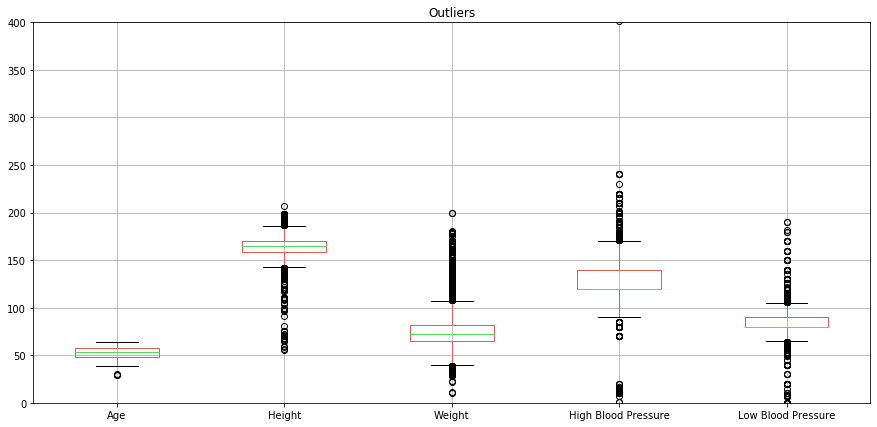

In [12]:
outlier = df[['Age','Height','Weight','High Blood Pressure','Low Blood Pressure']]

plt.figure(figsize = (15,7))
a = outlier.boxplot()
a.set_ylim(0,400)
plt.title('Outliers')
plt.show()

*Here I set the max limit of y-axis to 400 to visualize all the outliers clearly since the scale of blood pressure is much higher. Some of the outliers in blood pressure columns are not displayed since we clipped the y-axis but we can get a clear picture of the presence of outliers. We can observe that except Age all the other numerical features have outliers. High Blood Pressure and Low Blood Pressure have unusually high number of outliers.*

**Calculating outlier boundaries**

In [13]:
limit = pd.DataFrame(index=['Lower','Upper'])

for i in ['High Blood Pressure','Low Blood Pressure','Height','Weight']:
    IQR = df[i].quantile(0.75) - df[i].quantile(0.25)
    Lower = df[i].quantile(0.25) - (IQR * 3)
    Upper = df[i].quantile(0.75) + (IQR * 3)
    limit[i]= [Lower,Upper]
limit

,High Blood Pressure,Low Blood Pressure,Height,Weight
Lower,60.0,50.0,126.0,14.0
Upper,200.0,120.0,203.0,133.0


**Winsorizing outliers**

In [14]:
def max_(x,var,upp):
    return np.where(x[var]>upp,upp,x[var])
def min_(x,var,low):
    return np.where(x[var]<low,low,x[var])

In [15]:
df['High Blood Pressure'] = max_(df,'High Blood Pressure',200)
df['Low Blood Pressure'] = max_(df,'Low Blood Pressure',120)
df['Height'] = max_(df,'Height',203)
df['Weight'] = max_(df,'Weight',133)
df['High Blood Pressure'] = min_(df,'High Blood Pressure',60)
df['Low Blood Pressure'] = min_(df,'Low Blood Pressure',50)
df['Height'] = min_(df,'Height',126)
df['Weight'] = min_(df,'Weight',14)

**Visualization of categorical variables**

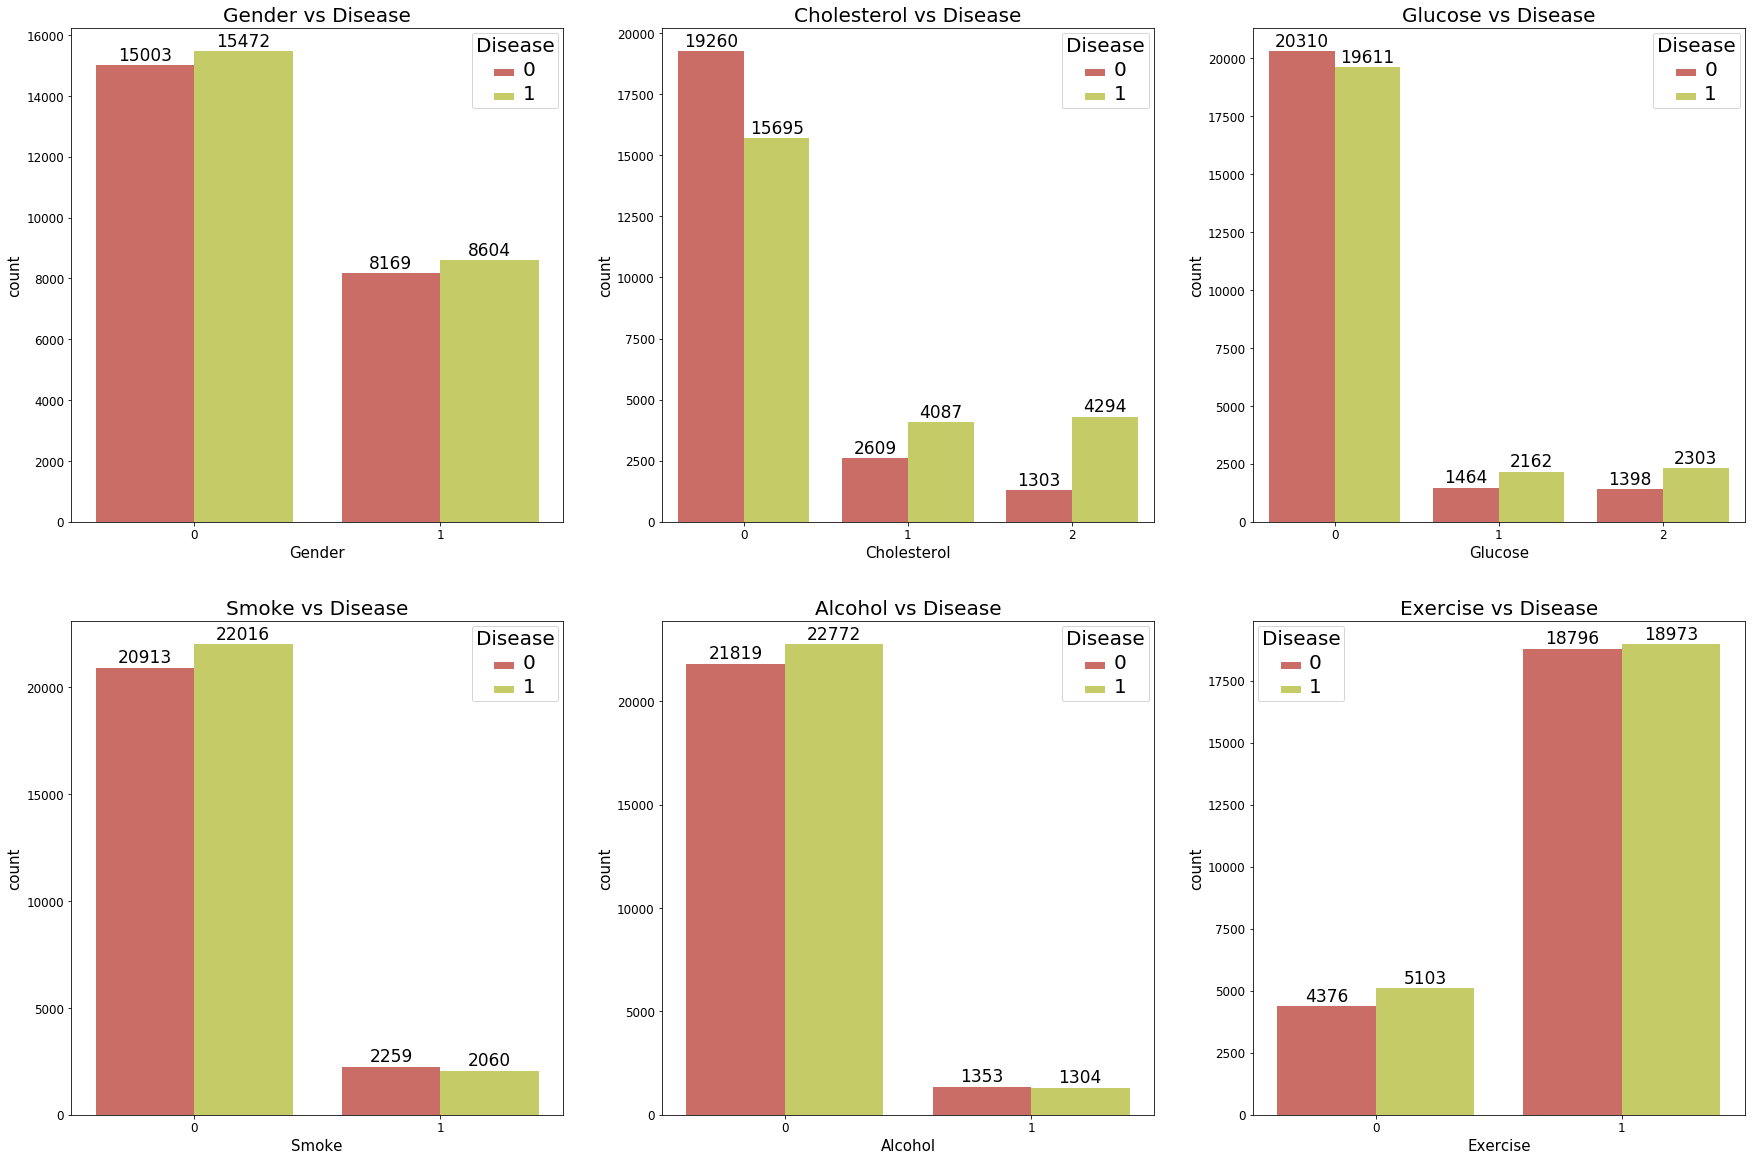

In [16]:
cat = ['Gender','Cholesterol','Glucose','Smoke','Alcohol','Exercise']

plt.figure(figsize=(30,20))

for i in range(len(cat)):
    #creating subplots
    plt.subplot(2,3,i+1)
    #plotting
    b = sb.countplot(df[cat[i]],hue=df['Disease'])
    #setting x and y labels
    b.set_xlabel(cat[i],fontsize=15)
    b.set_ylabel('count',fontsize=15)
    b.tick_params(labelsize=12)
    #size of legend
    plt.setp(b.get_legend().get_texts(), fontsize='20')
    plt.setp(b.get_legend().get_title(), fontsize='20')
    #title 
    plt.title('{} vs Disease'.format(cat[i]),fontsize=20)
    #values on top of bars
    for p in b.patches:
        b.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2., 
        p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points', fontsize = 17)

**Interpretation of countplots**

*For Gender, we find that there are more female patients with disease than males.*

*For Cholesterol, we can observe the percentage of the people with disease are high where cholesterol range is high and too high.*

*For Glucose, we can observe the percentage of the people with disease are high where Glucose range is high and too high.*

*For Smoke, Alcohol, Exercise there is no significant difference between smoker and non-smoker groups.*

**Visualization of numerical variables**

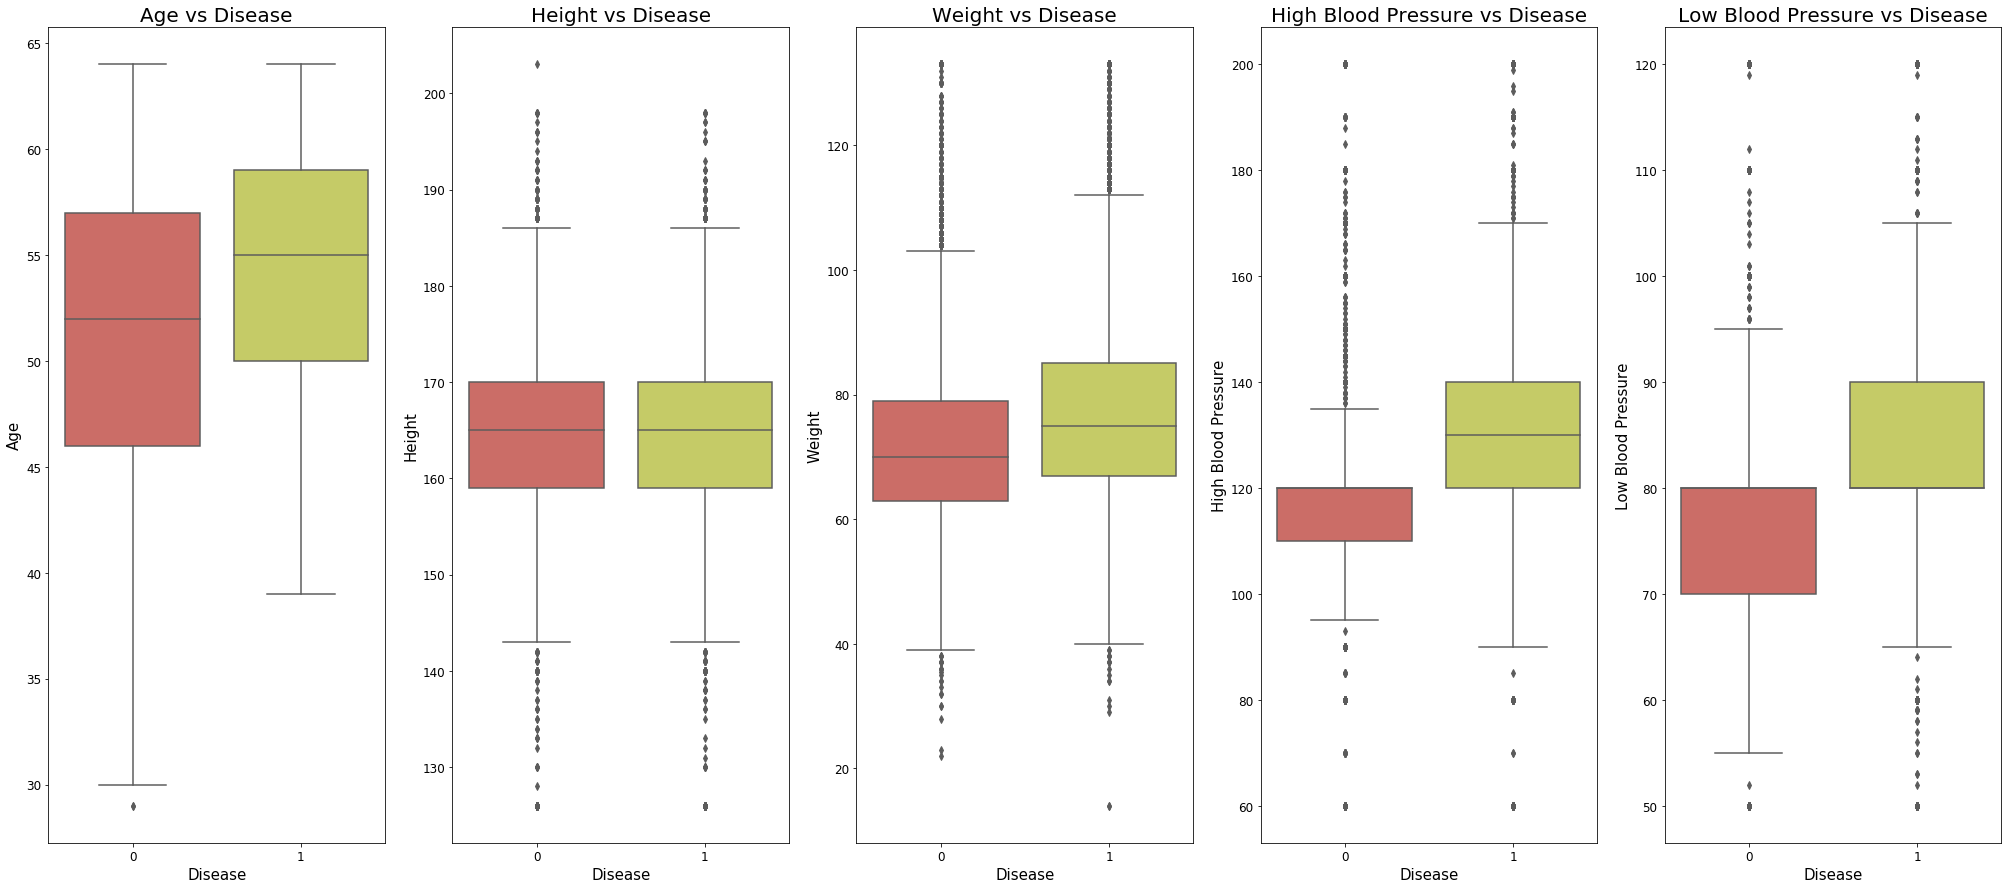

In [17]:
num = ['Age','Height','Weight','High Blood Pressure','Low Blood Pressure']

plt.figure(figsize=(35,15))

for i in range(len(num)):
    #creating subplots
    plt.subplot(1,5,i+1)
    #plotting
    a = sb.boxplot(x='Disease', y=num[i], data=df)
    #setting x and y axis labels
    a.set_xlabel('Disease',fontsize = 15)
    a.set_ylabel(num[i], fontsize = 15)
    a.tick_params(labelsize = 12)
    #plot title
    plt.title('{} vs Disease'.format(num[i]), fontsize = 20)

**Interpretation of boxplots**

*For Age, we can observe that elder people tend to have a high risk of heart disease.*

*For Height, we can observe that risk of heart disease doesnot depend on height.*

*For weight, we can observe that heavier people tend to have a high risk of heart disease.*

*For High Blood Pressure , if the values are higher than 120 and lower than 90, there is a risk of heart disease.*

*For Low Blood Pressure, if the values are higher than 80 and lower than 60, there is a risk of heart disease.*

**Exploring Target Variable**

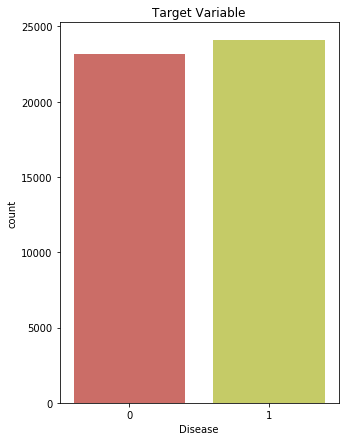

In [18]:
plt.figure(figsize=(5,7))
sb.countplot(df['Disease'])
plt.title('Target Variable')
plt.show()

*The data seems to be balanced.*

**Adding a new feature Body Mass Index (BMI)**

*The blood pressure is mainly influenced by factors such as smoking, being overweight or obese (indicated by body mass index), alcohol consumption, older age etc. Since there is no body mass index feature we can calculate it from height and weight using the formula below:*
 
$$Body Mass Index (BMI) = \frac{weight_{kilograms}}{height_{metres}^{2}}$$

In [19]:
df.insert(4,'BMI', round(df['Weight']/((df['Height']/100)**2),1)) 

**looking at final data prepared for modeling**

In [20]:
df.head()

,Age,Gender,Height,Weight,BMI,High Blood Pressure,Low Blood Pressure,Cholesterol,Glucose,Smoke,Alcohol,Exercise,Disease
0,59,0,167,88.0,31.6,130,68,0,0,0,0,1,0
1,64,0,150,71.0,31.6,140,100,0,0,0,0,0,1
2,41,0,166,83.0,30.1,100,70,0,0,0,1,1,0
3,50,1,172,110.0,37.2,130,80,0,0,1,0,1,0
4,39,0,162,61.0,23.2,110,80,1,1,0,0,1,0


**Correlation Matrix**

*Correlation matrix returns a table with correlation coeffiecients between all the variables in the data. Here we can observe the relation between all the features whether it is positive or negative, strong or weak etc.*

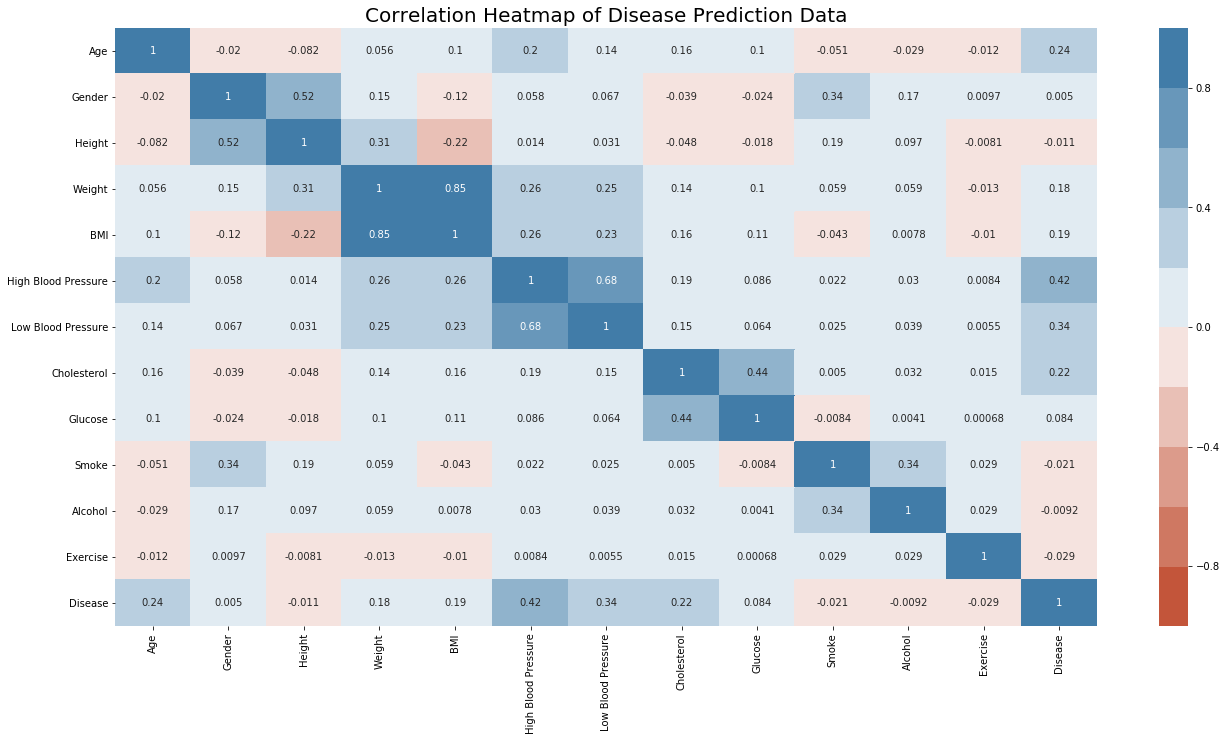

In [21]:
plt.figure(figsize=(22,11))

plt.title('Correlation Heatmap of Disease Prediction Data',fontsize=20)
sb.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, cmap=sb.diverging_palette(20, 240,n=10))
plt.show()

### SECTION 2 : MODELING, HYPER PARAMETER TUNING AND PERFORMANCE EVALUATION

**Classification Models :**<br/>
*Decision Tree*<br/>
*Logistic Regression*<br/>
*Neural Networks*<br/>
*Linear Support Vector Machine*<br/>
*Random Forest*<br/>
*Gradient Boosting Machine*<br/>

**Choice of Performance Evaluation Metrics**

**ROC curve:**
*A receiver operating characteristic curve, which is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings. A ROC curve can be used to select a threshold for a classifier which maximizes the true positives, while minimizing the false positives.*

*The true-positive rate is also known as sensitivity or recall.* 
*The false-positive rate is also known as (1 − specificity).* 


**AUC score:** 
*The AUC represents a model’s ability to discriminate between positive and negative classes. AUC values ranges from 0 to 1. An area of 1.0 represents a model that made all predictions perfectly. An area of 0.5 represents a model as 
random.*

*In addition to ROC-AUC metric, we use the other classification metrics in our models such as:*

* **Accuracy:** *It is the proportion of the total number of predictions that were correct over all kinds predictions made. Accuracy is a good measure when the target variable classes in the data are nearly balanced.*<br/>
*Accuracy = (TP + TN)/(TP + FP + FN + TN)*

* **Precision:** 
*It is also called Positive Predictive Value and is the proportion of positive cases that were correctly identified.*<br/>
*Precision = (TP) / (TP + FP)*

* **Recall or Sensitivity:** 
*It is the proportion of actual positive cases which are correctly identified.*<br/>
*Recall = (TP) / (TP + FN)*

* **F1 score:**
*f1 score is the harmonic mean of precision and recall.*<br/>

*Recall gives us information about a model performance with respect to false negatives , while precision gives us information about its performance with respect to false positives.*

*Since the dataset is balanced, we would want to maximize our Accuracy close to 100% without precision and recall too bad.*

**Function to print metrics**

In [22]:
def metrics(model_pred):
     metrics = {'Accuracy':round(accuracy_score(y_test,model_pred)*100,2),'Recall':round(recall_score(y_test,model_pred)*100,2),
                            'Precision':round(precision_score(y_test,model_pred)*100,2),'F1 Score':round(f1_score(y_test,model_pred)*100,2)}
     return metrics

**Function to plot training vs validation accuracy and Loss**

In [23]:
def plot_acc_loss(var):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(var.history['accuracy'])
    plt.plot(var.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='lower right ')
    
    plt.subplot(1,2,2)
    plt.plot(var.history['loss'])
    plt.plot(var.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.show()

**Function to print confusion matrix**

In [24]:
def confusion_matrix(model_pred):
    plt.figure(figsize=(4,3))
    sb.heatmap(pd.crosstab(y_test,model_pred),annot=True,fmt='d')
    plt.title('confusion matrix')
    plt.show()

**Function to generate ROC curve and calculate AUC score**

In [25]:
def plot_roc(model):
    plt.figure(figsize=(10,7))
    base_probs = [0 for _ in range(len(y_test))]

    best_probs = model.predict_proba(X_test)
    best_probs = best_probs[:, 1]

    base_fpr, base_tpr, _ = roc_curve(y_test, base_probs)
    best_fpr, best_tpr, _ = roc_curve(y_test, best_probs)

    plt.plot(base_fpr, base_tpr, linestyle='dashdot', label='Base Model',color='Green')
    plt.plot(best_fpr, best_tpr, marker='x', label='Best Model',color='Red',markeredgecolor='blue',markersize=2)

    plt.title('ROC curve')

    plt.legend()

    plt.show()
    
    best_auc = roc_auc_score(y_test, best_probs)

    print('Area under the curve for the model is %.3f' % (best_auc))

**Making a copy of data**

In [26]:
df_1 = df.copy()

### DECISION TREE

*Decision trees are supervised learning algorithms which learn from data to approximate a sine curve with a set of if-then-else rules. The deeper the tree, the more complex the decision rules and the fitter the model.*<br/>
*Decision tree builds classification models in the form of a tree structure. It breaks down a data set into smaller and smaller subsets while at the same time an associated decision tree is incrementally developed. The final result is a tree with decision nodes and leaf nodes. Leaf node represents a classification or decision. The top-most decision node in a tree which corresponds to the best predictor called root node. Decision trees can handle both categorical and numerical data.*

*The most important factors in buiding a decision tree are Entropy and Information Gain.*

**Selecting feature and target variables**

In [27]:
X_dt = df_1.drop(['Disease'],axis=1)
y_dt = df_1['Disease']

**Splitting into train and test set**

In [28]:
X_train,X_test,y_train,y_test = train_test_split(X_dt,y_dt,test_size=0.3,random_state=42)

**Running the model**

In [29]:
dt = DecisionTreeClassifier()

In [30]:
dt.fit(X_train,y_train)
dt_pred = dt.predict(X_test)

**Calculating performance evaluation metrics**

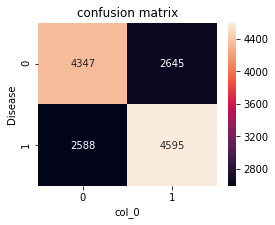

In [31]:
confusion_matrix(dt_pred)

In [32]:
metrics(dt_pred)

{'Accuracy': 63.08, 'Recall': 63.97, 'Precision': 63.47, 'F1 Score': 63.72}

**Hyperparameter tuning**

**GridSearch parameters:**

**criterion:** *The function to measure the quality of a split. Supported criteria are 'gini' for the Gini impurity and 'entropy' for the information gain.*

**min_samples_leaf:** *The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. This may have the effect of smoothing the model, especially in regression.*

**min_samples_split:** *The number of samples to split an internal node.*

**max_depth:** *The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.*

**max_leaf_nodes:** *Grow a tree with max_leaf_nodes in best-first fashion. Best nodes are defined as relative reduction in impurity. If None then unlimited number of leaf nodes.*



In [33]:
param_grid_dt = {'criterion': ['gini', 'entropy'],
              'min_samples_split': [2, 10, 20],
              'max_depth': [5, 10, 20],
              'min_samples_leaf': [1, 5, 10],
              'max_leaf_nodes': [2, 5, 10, 20]}
grid_dt = GridSearchCV(dt, param_grid_dt, cv=6, scoring='accuracy',verbose=1,n_jobs=-1)

In [34]:
#grid_dt.fit(X_train, y_train)

In [35]:
#grid_dt.best_estimator_

In [36]:
#print('best score is {:.2f}\n'.format(grid_dt.best_score_*100))
#grid_dt.best_params_

**Running the tuned model**

*Note :  For tuned model, I hardcoded the best params to avoid running the gridsearch everytime I start my jupyter notebook.*

In [37]:
dt_tuned = DecisionTreeClassifier(criterion='gini',max_depth= 5,max_leaf_nodes= 20,min_samples_leaf= 1,min_samples_split= 2)
dt_tuned.fit(X_train,y_train)
dt_tuned_pred = dt_tuned.predict(X_test)

**Calculating performance evaluation metrics and plotting ROC curve**

In [38]:
metrics(dt_tuned_pred)

{'Accuracy': 73.5, 'Recall': 69.89, 'Precision': 75.9, 'F1 Score': 72.77}

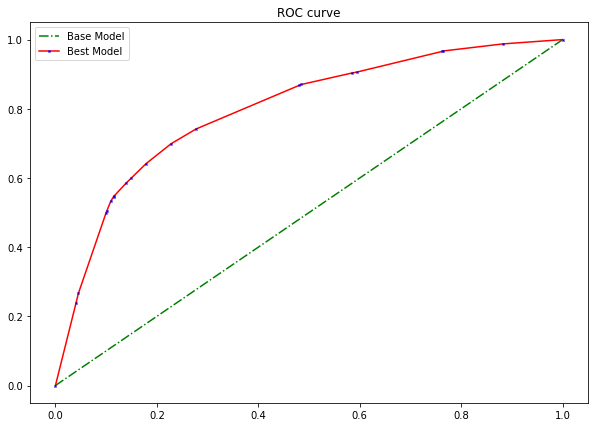

Area under the curve for the model is 0.797


In [39]:
plot_roc(dt_tuned)

**Table summarising base and tuned models**

In [40]:
base_dt = pd.DataFrame({'criterion': 'gini','max_depth': None,'max_leaf_nodes': None,'min_samples_leaf': 1,'min_samples_split': 2,
           'Accuracy':round(accuracy_score(y_test,dt_pred)*100,2),
           'Recall':round(recall_score(y_test,dt_pred)*100,2),
           'Precision':round(precision_score(y_test,dt_pred)*100,2),
           'F1 Score':round(f1_score(y_test,dt_pred)*100,2)},index=['base dt model'])
tuned_dt = pd.DataFrame({'criterion': 'gini','max_depth': 5,'max_leaf_nodes': 20,'min_samples_leaf': 1,'min_samples_split': 2,
           'Accuracy':round(accuracy_score(y_test,dt_tuned_pred)*100,2),
           'Recall':round(recall_score(y_test,dt_tuned_pred)*100,2),
           'Precision':round(precision_score(y_test,dt_tuned_pred)*100,2),
           'F1 Score':round(f1_score(y_test,dt_tuned_pred)*100,2)},index=['tuned dt model'])

dt_table = pd.concat([base_dt,tuned_dt])
dt_table


,criterion,max_depth,max_leaf_nodes,min_samples_leaf,min_samples_split,Accuracy,Recall,Precision,F1 Score
base dt model,gini,None,None,1,2,63.08,63.97,63.47,63.72
tuned dt model,gini,5,20,1,2,73.50,69.89,75.90,72.77


### LOGISTIC REGRESSION

*Logistic Regression works by predicting the probability that target variable belongs to a particular category by first fitting the data to a linear regression model, which is then passed to the sigmoid function which then outputs a value between 0 and 1 and can be interpreted as the probability. If the probability is above a certain predetermined threshold, then the model will predict Yes.*

**Selecting feature and target variables**

In [41]:
X_lg = df_1.drop(['Disease'],axis=1)
y_lg = df_1['Disease']

**Scaling the feature variable**

In [42]:
X_lg = StandardScaler().fit_transform(X_lg)

**Splitting into train and test set**

In [43]:
X_train,X_test,y_train,y_test = train_test_split(X_lg,y_lg,test_size=0.3,random_state=42)

**Running the model**

In [44]:
lg = LogisticRegression()
lg.fit(X_train,y_train)
lg_pred = lg.predict(X_test)

**Calculating performance evaluation metrics**

In [45]:
metrics(lg_pred)

{'Accuracy': 73.17, 'Recall': 69.98, 'Precision': 75.32, 'F1 Score': 72.56}

**Hyperparameter tuning**

**GridSearch parameters:**

**C:**
*Inverse of regularization strength; must be a positive value. Like in support vector machines, smaller values specify stronger regularization.*<br/>

**penalty:**
*Penalty is used to specify the norm used in the penalization. The ‘newton-cg’, ‘sag’ and ‘lbfgs’ solvers support only l2 penalties. ‘elasticnet’ is only supported by the ‘saga’ solver.*

**solver:**
*Algorithm to use in the optimization problem.*
*For small datasets, ‘liblinear’ is a good choice, whereas ‘sag’ and ‘saga’ are faster for large ones.*
*For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ handle multinomial loss; ‘liblinear’ is limited to one-versus-rest schemes.*

In [46]:
param_grid_lg = {'C':[0.001,0.01,0.1,1],'penalty':['l1','l2'] ,'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],'warm_start':[True,False]}
grid_lg = GridSearchCV(estimator=lg,param_grid=param_grid_lg,scoring='accuracy',verbose=4,n_jobs=-1)

In [47]:
#grid_lg.fit(X_train,y_train)

In [48]:
#grid_lg.best_params_

In [49]:
#grid_lg.best_score_

In [50]:
lg_tuned = LogisticRegression(C=1,penalty='l1',solver='liblinear')
lg_tuned.fit(X_train,y_train)
lg_tuned_pred = lg_tuned.predict(X_test)

**Calculating peformance evaluation metrics and plotting ROC curve**

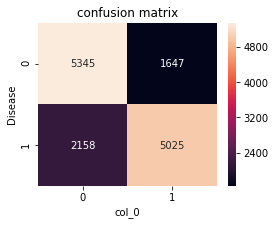

In [51]:
confusion_matrix(lg_tuned_pred)

In [52]:
metrics(lg_tuned_pred)

{'Accuracy': 73.16, 'Recall': 69.96, 'Precision': 75.31, 'F1 Score': 72.54}

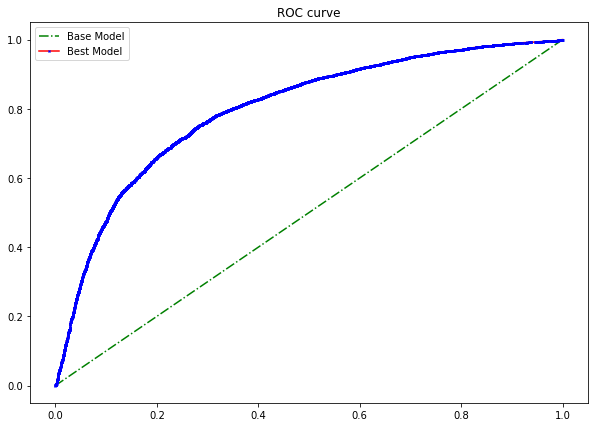

Area under the curve for the model is 0.798


In [53]:
plot_roc(lg_tuned)

**Table summarising base and tuned models**

In [54]:
base_lg_params={'C':1,'penalty':'l2','solver':'lbfgs'}
tuned_lg_params={'C':1,'penalty':'l1','solver':'liblinear'}
base_lg_params.update(metrics(lg_pred))
tuned_lg_params.update(metrics(lg_tuned_pred))

In [55]:
lg_table = pd.concat([pd.DataFrame(base_lg_params,index=['base model']),
                      pd.DataFrame(tuned_lg_params,index=['tuned model'])])
lg_table

,C,penalty,solver,Accuracy,Recall,Precision,F1 Score
base model,1,l2,lbfgs,73.17,69.98,75.32,72.56
tuned model,1,l1,liblinear,73.16,69.96,75.31,72.54


### NEURAL NETWORKS

*Neural Networks consists of artificial neurons called Perceptron. A perceptron takes several binary inputs and produces a single binary output. The neuron's output, 0 or 1, is determined by whether the weighted sum is less than or greater than some threshold value. Just like the weights, the threshold is a real number which is a parameter of the neuron.*

*A neural network is trained by adjusting neuron input weights based on the network's performance on example inputs. If the network classifies the target correctly, weights contributing to the correct answer are increased, while other weights are decreased.*

**Selecting feature and target variable**

In [56]:
X_n = df_1.drop(['Disease'],axis=1)
y_n = df_1.Disease

**Scaling the feature variable**

In [57]:
X_n = StandardScaler().fit_transform(X_n)

**Splitting into train and test set**

In [58]:
X_train,X_test,y_train,y_test = train_test_split(X_n,y_n,test_size=0.3,random_state=42)

**Building the model**

**Sequential:** *It is the model type we use to build the model in Keras. It allows us to build the model layer by layer.Each layer has some weight which corresponds to the layer that follows it.*

**add:** *add function is used for adding a layer to the network.*

**Dense:** *It is a layer type. In this type all the nodes previous layer are connected to the nodes in current layer.*

**Dropout:** *Dropout is a regularization method that approximates training a large number of neural networks with different architectures in parallel. During training, some number of layer outputs are randomly ignored or “dropped out.” This has the effect of making the layer look-like and be treated-like a layer with a different number of nodes and connectivity to the prior layer.*

*Dropout has the effect of making the training process noisy, forcing nodes within a layer to probabilistically take on more or less responsibility for the inputs. This suggests that perhaps dropout breaks-up the situations where network layers co-adapt to correct mistakes from prior layers, in turn making the model more robust.*

**Activation:** *The activation function is a mathematical gate between the input feeding the current neuron and its output going to the next layer. It can be as simple as a step function that turns the neuron output on and off, depending on a rule or threshold.*

*    **Sigmoid function:** *We are going to use sigmoid as our activation function for output layer. It is generally a special case of softmax function which is used for binary classification problems. Sigmoid should not be used as activation function for the hidden layer. This is because of the vanishing gradient problem, i.e., if your input is on a higher side (where sigmoid goes flat) then the gradient will be near zero. This will cause very slow or no learning during backpropagation as weights will be updated with really small values.*
*    **ReLU function:** *We will be using ReLU function for hidden layers. The rectified linear activation function (ReLU) will output the input directly if is positive, otherwise, it will output zero. It has become the default activation function for many types of neural networks because a model that uses it is easier to train and often achieves better performance.*

**Loss:** *It's a method of evaluating how well specific algorithm models the given data. If predictions deviates too much from actual results, loss function gives a very large number.*
*    **Binary cross entropy loss function:** *Cross-entropy is a measure of the difference between two probability distributions for a given random variable or set of events. Looking at the binary cross entropy formula we can interpret that, for example if the target variable is correctly predicted to be 1 it adds log(p(y)) to the loss and  at the same time it adds log(1-p(y)) for target variable 0.*

**Optimizer:** *0ptimizers are algorithms used to change the attributes of the neural network such as weights and learning rate in order to reduce the losses.*
*    **SGD optimizer:** *We are using SGD optimizer. In SGD we calculate the cost of one training example for each step and updates the parameters of the network, which speeds up neural networks greatly.*

**Epochs:** *One Epoch is when an entire dataset is passed forward and backward through the neural network only once. The number of epochs is the number of times the model will cycle through the data. The more epochs we run, the more the model will improve, up to a certain point. After that point, the model will stop improving during each epoch.*

**Batch size:** *Instead of passing the entire dataset into the neural network at once, it is divided into number of batches. Batch size is the total number of training examples present in a single batch.*

### Neural Network with zero hidden layers

In [59]:
def create_():
    model = Sequential()
    model.add(Dense(1,input_shape=(12,),activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='sgd',metrics=['accuracy'])
    return model

# create model
ANN0 = KerasClassifier(build_fn=create_) 

In [60]:
ANN0.fit(X_train,y_train)

Epoch 1/1
33073/33073 [==============================] - 1s 18us/step - loss: 0.6138 - accuracy: 0.6844


In [61]:
ANN0_pred = [x[0] for x in ANN0.predict(X_test)]

**Calculating performance evaluation metrics and plotting ROC curve**

In [62]:
metrics(ANN0_pred)

{'Accuracy': 72.38, 'Recall': 69.9, 'Precision': 74.12, 'F1 Score': 71.95}

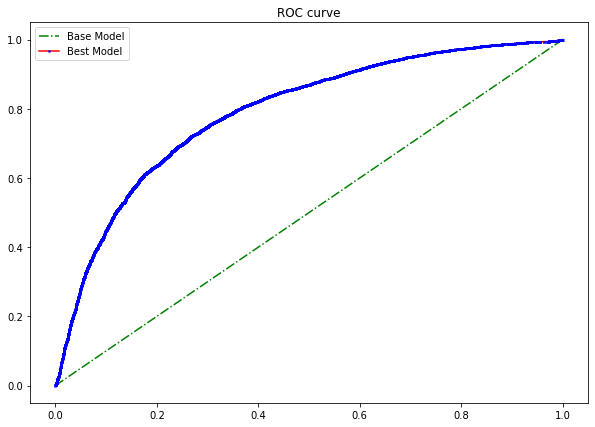

Area under the curve for the model is 0.791


In [63]:
plot_roc(ANN0)

**Hyperparameter tuning**

In [64]:
param_grid_ANN0 = dict(epochs=[20,30,40],batch_size=[10,20,30])
grid_ANN0 = GridSearchCV(estimator = ANN0, param_grid=param_grid_ANN0, verbose=1, n_jobs=-1, cv=4)

In [65]:
#grid_ANN0.fit(X_train,y_train)

In [66]:
#grid_ANN0.best_params_

In [67]:
#grid_ANN0.best_score_

**Running the tuned model**

In [68]:
ANN0_tuned = KerasClassifier(build_fn=create_, batch_size=10, epochs=40)
var_ANN0 = ANN0_tuned.fit(X_train,y_train,validation_data=(X_test,y_test))

Train on 33073 samples, validate on 14175 samples
Epoch 1/40
33073/33073 [==============================] - 2s 65us/step - loss: 0.5807 - accuracy: 0.7060 - val_loss: 0.5563 - val_accuracy: 0.7299
Epoch 2/40
33073/33073 [==============================] - 2s 63us/step - loss: 0.5650 - accuracy: 0.7247 - val_loss: 0.5572 - val_accuracy: 0.7316
Epoch 3/40
33073/33073 [==============================] - 2s 64us/step - loss: 0.5649 - accuracy: 0.7243 - val_loss: 0.5573 - val_accuracy: 0.7311
Epoch 4/40
33073/33073 [==============================] - 2s 68us/step - loss: 0.5649 - accuracy: 0.7251 - val_loss: 0.5565 - val_accuracy: 0.7293
Epoch 5/40
33073/33073 [==============================] - 2s 65us/step - loss: 0.5650 - accuracy: 0.7252 - val_loss: 0.5567 - val_accuracy: 0.7323
Epoch 6/40
33073/33073 [==============================] - 2s 64us/step - loss: 0.5649 - accuracy: 0.7258 - val_loss: 0.5569 - val_accuracy: 0.7309
Epoch 7/40
33073/33073 [==============================] - 2s 64us/st

**Plotting accuracy and loss between training and validation sets**

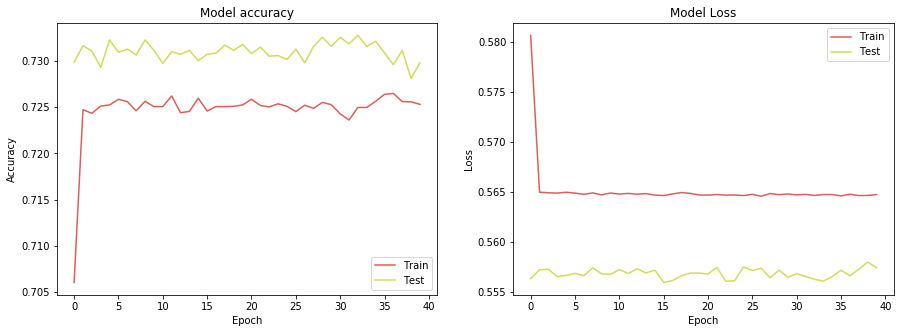

In [69]:
plot_acc_loss(var_ANN0)

In [70]:
ANN0_tuned_pred = [x[0] for x in ANN0_tuned.predict(X_test)]

**Calculating performance evaluation metrics and plotting ROC curve**

In [71]:
metrics(ANN0_tuned_pred)

{'Accuracy': 72.98, 'Recall': 70.0, 'Precision': 75.01, 'F1 Score': 72.42}

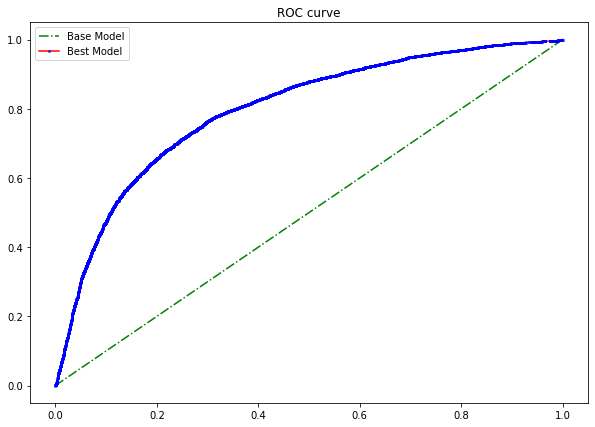

Area under the curve for the model is 0.797


In [72]:
plot_roc(ANN0_tuned)

### Neural Network with 1 hidden layer

In [73]:
def create_1(drop):
    model = Sequential()
    model.add(Dense(11,input_shape=(12,),activation='relu'))
    model.add(Dropout(drop))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='sgd',metrics=['accuracy'])
    return model

# create model
ANN1 = KerasClassifier(build_fn=create_1,drop=0.0) 

In [74]:
ANN1.fit(X_train,y_train)

Epoch 1/1
33073/33073 [==============================] - 1s 20us/step - loss: 0.6307 - accuracy: 0.6396


In [75]:
ANN1_pred = [x[0] for x in ANN1.predict(X_test)]

**Calculating performance evaluation metrics and plotting ROC curve**

In [76]:
metrics(ANN1_pred)

{'Accuracy': 71.68, 'Recall': 73.56, 'Precision': 71.41, 'F1 Score': 72.47}

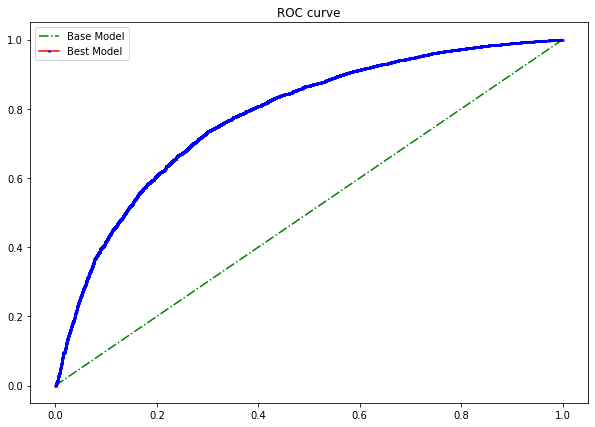

Area under the curve for the model is 0.780


In [77]:
plot_roc(ANN1)

**Hyperparameter tuning**

In [78]:
param_grid_ANN1 = {'epochs':[20,30,40],'batch_size':[10,20,30], 'drop':[0.1,0.2,0.3]}
grid_ANN1 = GridSearchCV(estimator=ANN1,param_grid=param_grid_ANN1,verbose=1,n_jobs=-1,cv=4)

In [79]:
#grid_ANN1.fit(X_train,y_train)

In [80]:
#grid_ANN1.best_params_

In [81]:
#grid_ANN1.best_score_

**Running the tuned model**

In [82]:
ANN1_tuned = KerasClassifier(build_fn=create_1,drop =0.1,batch_size=10, epochs=30)
var_ANN1 = ANN1_tuned.fit(X_train,y_train,validation_data=(X_test,y_test));

Train on 33073 samples, validate on 14175 samples
Epoch 1/30
33073/33073 [==============================] - 3s 84us/step - loss: 0.5958 - accuracy: 0.6836 - val_loss: 0.5562 - val_accuracy: 0.7239
Epoch 2/30
33073/33073 [==============================] - 3s 80us/step - loss: 0.5662 - accuracy: 0.7179 - val_loss: 0.5516 - val_accuracy: 0.7270
Epoch 3/30
33073/33073 [==============================] - 3s 80us/step - loss: 0.5639 - accuracy: 0.7201 - val_loss: 0.5491 - val_accuracy: 0.7314
Epoch 4/30
33073/33073 [==============================] - 3s 80us/step - loss: 0.5623 - accuracy: 0.7233 - val_loss: 0.5482 - val_accuracy: 0.7321
Epoch 5/30
33073/33073 [==============================] - 3s 81us/step - loss: 0.5623 - accuracy: 0.7236 - val_loss: 0.5472 - val_accuracy: 0.7327
Epoch 6/30
33073/33073 [==============================] - 3s 82us/step - loss: 0.5602 - accuracy: 0.7245 - val_loss: 0.5468 - val_accuracy: 0.7341
Epoch 7/30
33073/33073 [==============================] - 3s 81us/st

**Plotting accuracy and loss between training and validation sets**

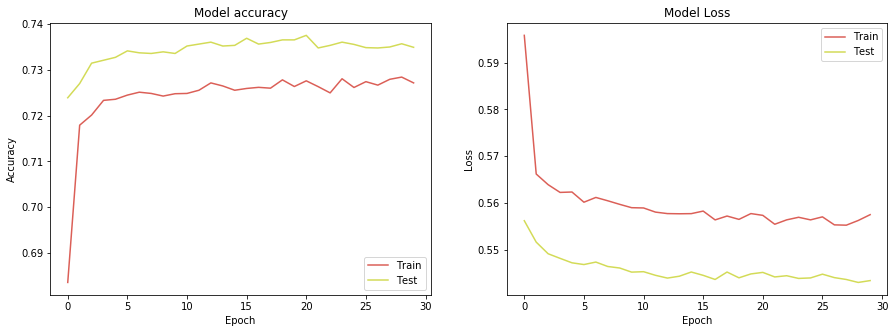

In [83]:
plot_acc_loss(var_ANN1)

In [84]:
ANN1_tuned_pred = [x[0] for x in ANN1_tuned.predict(X_test)]

**Calculating performance evaluation metrics and plotting ROC curve**

In [85]:
metrics(ANN1_tuned_pred)

{'Accuracy': 73.49, 'Recall': 71.5, 'Precision': 75.01, 'F1 Score': 73.21}

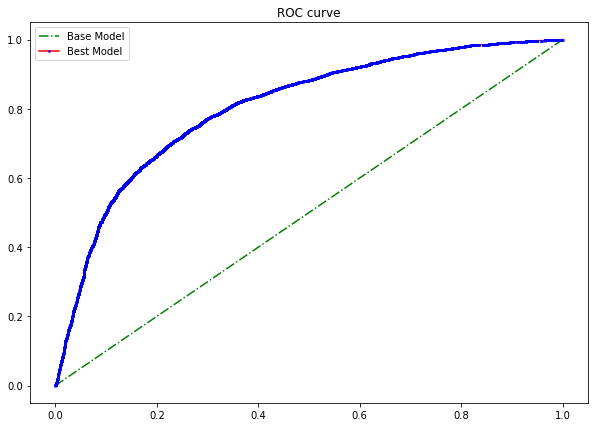

Area under the curve for the model is 0.806


In [86]:
plot_roc(ANN1_tuned)

### Neural Network with 2 hidden layers

In [87]:
def create_2(neurons,drop):
    model = Sequential()
    model.add(Dense(11,input_shape=(12,),activation='relu'))
    model.add(Dropout(drop))
    model.add(Dense(neurons, activation='relu'))
    model.add(Dropout(drop))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='sgd',metrics=['accuracy'])
    return model

# create model
ANN2 = KerasClassifier(build_fn=create_2, neurons=5, drop=0.1)

In [88]:
ANN2.fit(X_train,y_train)

Epoch 1/1
33073/33073 [==============================] - 1s 26us/step - loss: 0.6439 - accuracy: 0.6279


In [89]:
ANN2_pred = [x[0] for x in ANN2.predict(X_test)]

In [90]:
metrics(ANN2_pred)

{'Accuracy': 71.13, 'Recall': 73.94, 'Precision': 70.52, 'F1 Score': 72.19}

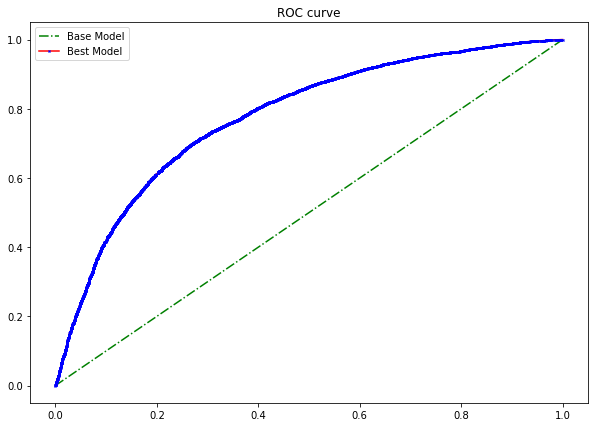

Area under the curve for the model is 0.777


In [91]:
plot_roc(ANN2)

**Hyperparameter tuning**

In [92]:
param_grid_ANN2 = {'epochs':[20,30,40],'batch_size':[10,20,30], 'drop':[0.2,0.3], 'neurons':[4,5,6]}
grid_ANN2 = GridSearchCV(estimator=ANN2,param_grid=param_grid_ANN2,verbose=1,n_jobs=-1,cv=4)

In [93]:
#grid_ANN2.fit(X_train,y_train)

In [94]:
#grid_ANN2.best_params_

In [95]:
#grid_ANN2.best_score_

**Running the tuned model**

In [96]:
ANN2_tuned = KerasClassifier(build_fn=create_2, neurons = 5 , drop =0.2,batch_size=10, epochs=40)
var_ANN2 = ANN2_tuned.fit(X_train,y_train,validation_data=(X_test,y_test));

Train on 33073 samples, validate on 14175 samples
Epoch 1/40
33073/33073 [==============================] - 3s 94us/step - loss: 0.6316 - accuracy: 0.6432 - val_loss: 0.5662 - val_accuracy: 0.7194
Epoch 2/40
33073/33073 [==============================] - 3s 88us/step - loss: 0.5928 - accuracy: 0.6950 - val_loss: 0.5539 - val_accuracy: 0.7260
Epoch 3/40
33073/33073 [==============================] - 3s 88us/step - loss: 0.5872 - accuracy: 0.7027 - val_loss: 0.5508 - val_accuracy: 0.7304
Epoch 4/40
33073/33073 [==============================] - 3s 88us/step - loss: 0.5793 - accuracy: 0.7077 - val_loss: 0.5499 - val_accuracy: 0.7304
Epoch 5/40
33073/33073 [==============================] - 3s 88us/step - loss: 0.5767 - accuracy: 0.7130 - val_loss: 0.5492 - val_accuracy: 0.7324
Epoch 6/40
33073/33073 [==============================] - 3s 89us/step - loss: 0.5745 - accuracy: 0.7106 - val_loss: 0.5482 - val_accuracy: 0.7326
Epoch 7/40
33073/33073 [==============================] - 3s 89us/st

**Plotting accuracy and loss between training and validation sets**

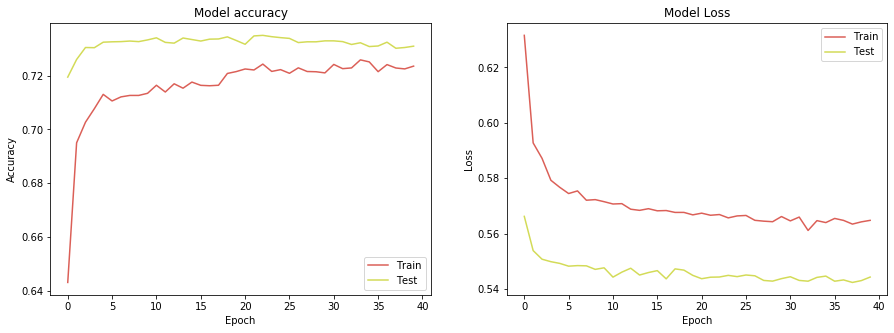

In [97]:
plot_acc_loss(var_ANN2)

In [98]:
ANN2_tuned_pred = [x[0] for x in ANN2_tuned.predict(X_test)]

In [99]:
metrics(ANN2_tuned_pred)

{'Accuracy': 73.09, 'Recall': 67.01, 'Precision': 76.92, 'F1 Score': 71.62}

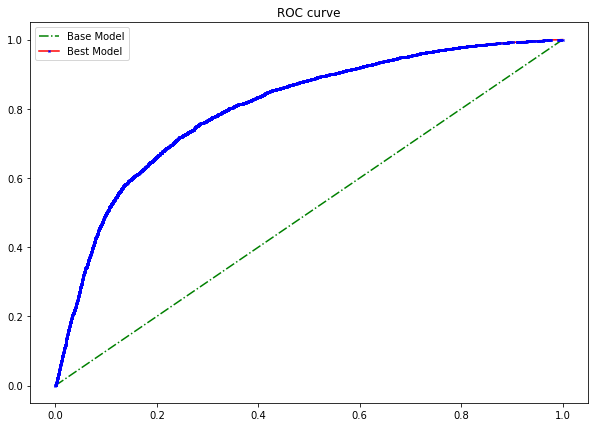

Area under the curve for the model is 0.804


In [100]:
plot_roc(ANN2_tuned)

### LINEAR SVM

*Note: Considering the best LinearSVM model from HW3*

**Parameters:**

**C:** *Regularization parameter. The strength of the regularization is inversely proportional to C.*
* *By increasing C, the bias is reduced and variance is increased thereby increasing the risk of overfitting.*

* *By decreasing C the variance will decrease and reduce the risk of overfitting, but the bias increases which in turn increases the risk of underfitting.*

*Hence an optimum value of C has to be chosen so that we get an unbiased and low variance model.*

**penalty:** *Specifies the norm used in the penalization. The ‘l2’ penalty is the standard used in SVC.*

**loss:** *Specifies the loss function. ‘hinge’ is the standard SVM loss while ‘squared_hinge’ is the square of the hinge loss.*

**Selecting feature and target variables**

In [101]:
X_lsvm = df_1.drop(['Disease'],axis = 1)
y_lsvm = df_1['Disease']

**Scaling the feature variable**

In [102]:
scaled_lsvm = StandardScaler().fit_transform(X_lsvm)

**Splitting the data into train and test set**

In [103]:
X_train,X_test,y_train,y_test = train_test_split(scaled_lsvm,y_lsvm,test_size=0.3,random_state=42)

**Running the model**

In [104]:
lsvm = LinearSVC(C=1, loss='hinge', penalty='l2')
lsvm.fit(X_train,y_train)
lsvm_pred = lsvm.predict(X_test)

**Calculating performance evaluation metrics**

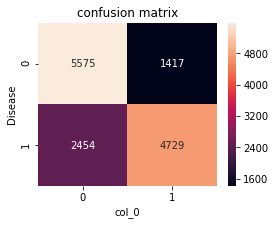

In [105]:
confusion_matrix(lsvm_pred)

In [106]:
metrics(lsvm_pred)

{'Accuracy': 72.69, 'Recall': 65.84, 'Precision': 76.94, 'F1 Score': 70.96}

### RANDOM FOREST

*Random forest is an ensemble learning method for classification that operate by constructing a multitude of decision trees. Each decision tree gives out a class prediction and the class with most votes becomes the model's prediction. Random decision forests correct for decision trees' habit of overfitting to their training set.*

*Note: Considering the best RandomForest model from HW3*

**Parameters:**

**criterion:**
*The function to measure the quality of a split. Supported criteria are 'gini' for the Gini impurity and 'entropy' for the information gain.*

**min_samples_leaf:** *The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. This may have the effect of smoothing the model, especially in regression.*

**min_samples_split:** *The number of samples to split an internal node.*

**max_depth:** *The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.*

**max_features:** *The number of features to consider when looking for the best split.*
* *If 'auto', then max_features=sqrt(n_features).*
* *If 'log2', then max_features=log2(n_features).*

**n_estimators:** *The number of trees in the forest.*

**Selecting feature and target variables**

In [107]:
X_rf = df_1.drop(['Disease'],axis = 1)
y_rf = df_1['Disease']

**Splitting the data into train and test sets**

In [108]:
X_train,X_test,y_train,y_test = train_test_split(X_rf,y_rf,test_size=0.3,random_state=42)

**Running the model**

In [109]:
rf = RandomForestClassifier(criterion ='entropy', min_samples_leaf= 4, min_samples_split= 10,max_depth=10,max_features='log2',n_estimators=400)
rf.fit(X_train,y_train)
rf_pred = rf.predict(X_test)

**Calculating performacne evaluation metrics and plotting ROC curve**

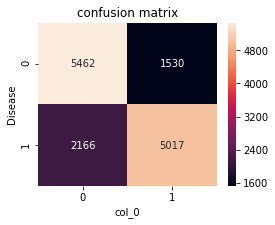

In [110]:
confusion_matrix(rf_pred)

In [111]:
metrics(rf_pred)

{'Accuracy': 73.93, 'Recall': 69.85, 'Precision': 76.63, 'F1 Score': 73.08}

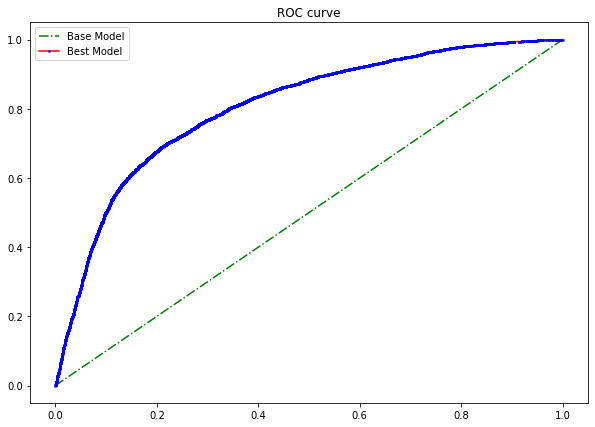

Area under the curve for the model is 0.806


In [112]:
plot_roc(rf)

### GRADIENT BOOSTING MACHINE

*Gradient boosting is a machine learning technique for regression and classification problems, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees. It builds the models in a stage-wise fashion. The final prediction model is taken by making weighted average of predictions amde by each weak model.*

*Note: Considering the best GBM model from HW3*

**Parameters:**

**learning_rate:** *learning rate shrinks the contribution of each tree by learning_rate value. There is a trade-off between learning_rate and n_estimators.*

**n_estimators:** *The number of boosting stages to perform. Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance.*

**max_depth:** *maximum depth of the individual regression estimators. The maximum depth limits the number of nodes in the tree.*

**Selecting feature and target variables**

In [113]:
X_gbm = df_1.drop(['Disease'],axis = 1)
y_gbm = df_1['Disease']

**Splitting the data into train and test sets**

In [114]:
X_train,X_test,y_train,y_test = train_test_split(X_gbm,y_gbm, test_size = 0.3, random_state = 42)

**Running the model**

In [115]:
gbm = GradientBoostingClassifier(learning_rate=0.02, max_depth=3,n_estimators=400)
gbm.fit(X_train,y_train)
gbm_pred = gbm.predict(X_test) 

**Calculating performance evaluation metrics and plotting ROC curve**

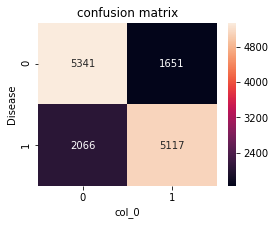

In [116]:
confusion_matrix(gbm_pred)

In [117]:
metrics(gbm_pred)

{'Accuracy': 73.78, 'Recall': 71.24, 'Precision': 75.61, 'F1 Score': 73.36}

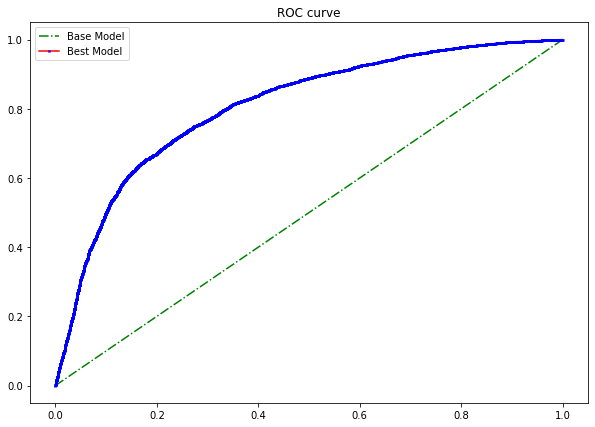

Area under the curve for the model is 0.808


In [118]:
plot_roc(gbm)

### Comparison between SVM, Logistic Regression and Single Layer Perceptron

**Performance table**

*Note: Considering best models only for comparison*

In [123]:
#linear svm
svm_c = metrics(lsvm_pred)
svm_c.update({'Auc score':'None','Time ( hr )':0.016})
#logistic regression
lg_c = metrics(lg_tuned_pred)
lg_c.update({'Auc score':0.798,'Time ( hr )':0.016})
#single layer perceptron
ann0_c = metrics(ANN0_tuned_pred)
ann0_c.update({'Auc score':0.797,'Time ( hr )':0.283})

In [124]:
cmp = pd.DataFrame([svm_c,lg_c,ann0_c],index=['Linear SVM','Logistic Regression','Artificial Neural Network 0'])
cmp

,Accuracy,Recall,Precision,F1 Score,Auc score,Time ( hr )
Linear SVM,72.69,65.84,76.94,70.96,None,0.016
Logistic Regression,73.16,69.96,75.31,72.54,0.798,0.016
Artificial Neural Network 0,72.98,70.00,75.01,72.42,0.797,0.283


**Discussion**

*All the 3 models, LinearSVM, Logistic Regression, Single Layer Perceptron, exhibit similar performances in classifying whether a person has disease or not based on the inputs given to them.*

*Incase of LinearSVM and Artificial Neural Networks, the decision boundary is the same y = wx+b. The difference is in the training and the loss fucntion being used for optimization. SVM tries to create one or more hyperplanes to seperate the data into classes. If the problem is linearly seperable, the single layer perceptron also tries to create a hyperplane to classify the data into two classes. We can say that SVM without any kernel tricks is similar to single layer perceptron.*

*Logistic Regression uses sigmoid function to classify the data which is a special case of Softmax function used for binary classification. Logistic Regression is a generalized linear model i.e., it cannot capture complex non-linear relationship of the features. Also it means the target variable is connected through a link function(sigmoid function) to the feature variables. The logistic regression tries to fit the model such that the square of distance between the sigmoid curve and the datapoint is minimum.*

### SECTION 3 : COMBINATION AND COMPARISON OF MULTIPLE MACHINE LEARNING ALGORITHMS

**Performance table**

In [125]:
#decision tree
dt_c = metrics(dt_tuned_pred)
dt_c.update({'Auc score':0.797,'Time ( hr )':0.03})
#random forest
rf_c = metrics(rf_pred)
rf_c.update({'Auc score':0.806,'Time ( hr )':1})
#gradient boosting machine
gbm_c = metrics(gbm_pred)
gbm_c.update({'Auc score':0.808,'Time ( hr )':2})

In [126]:
cmp2 = pd.DataFrame([lg_c,dt_c,rf_c,gbm_c ],
            index = ['Logistic Regression','Decision Tree','Random Forest','Gradient Boosting'])
cmp2

,Accuracy,Recall,Precision,F1 Score,Auc score,Time ( hr )
Logistic Regression,73.16,69.96,75.31,72.54,0.798,0.016
Decision Tree,73.50,69.89,75.90,72.77,0.797,0.030
Random Forest,73.93,69.85,76.63,73.08,0.806,1.000
Gradient Boosting,73.78,71.24,75.61,73.36,0.808,2.000


**Relative importance of Logistic Regression**

In [127]:
cols = df_1.drop(['Disease'],axis=1).columns
w = pd.DataFrame(list(zip(cols, [x for x in lg_tuned.coef_.tolist()[0]])),
            columns = ['feature','LR']).sort_values('LR',ascending=False)

**Function to get feature importance and return them in a dataframe**

In [128]:
def importance(model,name):
    d = pd.DataFrame(list(zip(cols, model.feature_importances_)),
            columns = ['feature',name]).sort_values(name,ascending=False)
    return d

**Relative importances of Gradient Boosting Machine**

In [129]:
x = importance(gbm,'GBM')

**Relative importances of Random Forest**

In [130]:
y = importance(rf,'RF')

**Relative importances of Decision Tree**

In [131]:
z = importance(dt_tuned,'DT')

**Summarising all the relative importances**

In [132]:
d = [w,x,y,z]

In [133]:
from functools import reduce

In [134]:
relative_imp = reduce(lambda  left,right: pd.merge(left,right,on=['feature'],how='outer'), d)

*Since we are asked to compare Decision Tree with other models, I sorted the feature importances based on Decision Tree model.*

In [135]:
relative_imp.sort_values('DT',ascending=False)

,feature,LR,GBM,RF,DT
0,High Blood Pressure,0.856500,0.752219,0.428140,0.807759
1,Age,0.332316,0.110942,0.120217,0.108659
2,Cholesterol,0.318297,0.066126,0.073143,0.067488
10,Glucose,-0.072730,0.002900,0.013004,0.006716
5,BMI,0.000000,0.014546,0.065510,0.006650
3,Low Blood Pressure,0.209911,0.024876,0.184244,0.002729
4,Weight,0.146937,0.012935,0.053115,0.000000
6,Gender,-0.011800,0.000712,0.005880,0.000000
7,Height,-0.029108,0.004838,0.036363,0.000000
8,Alcohol,-0.042080,0.001240,0.004976,0.000000


**Interpretations**

*The top features that are helpful in predicting whether a person has disease or not:*

*    *Decision Tree : High Blood Pressure, Age, Cholesterol, Glucose and BMI.*

*    *For Logistic Regression : Cholesterol, Age, High Blood Pressure, Weight and Low Blood Pressure.*

*    *For Gradient Boosting : High Blood Pressure, Age, Cholesterol, Low Blood Pressure and BMI.*

*    *For Random Forest : High Blood Pressure, Low Blood Pressure, Age, Cholesterol and BMI.*


*Looking at the top features of Logistic Regression, Gradient Boosting and Random Forest, we can observe the most important features in predicting the Disease are High Blood Pressure, Low Blood Pressure, Age, Cholesterol and BMI.*

*Out of these we have 4 features that are same as the top features produced by the Decision Tree model. So we can say that the model is consistent with findings produced by other learning algorithms in predicting whether a person has disease or not.*


### MASTER TABLE SUMMARISING ALL THE MODELS

*Note: metrics for models from HW3 are hardcoded*

In [136]:
nbc_c = {'Accuracy': 71.12,'Recall': 62.22,'Precision': 76.41,'F1 Score': 68.59,'Auc score':0.783,'Time ( hr )':0.002}
knn_c = {'Accuracy': 72.47,'Recall': 70.05,'Precision': 76.41,'F1 Score': 72.06,'Auc score':0.789,'Time ( hr )':0.25}
rbf_c = {'Accuracy': 73.53,'Recall': 68.98,'Precision': 76.48,'F1 Score': 72.54,'Auc score':'None','Time ( hr )':1.2}
ann1_c = metrics(ANN1_tuned_pred)
ann1_c.update({'Auc score':0.806,'Time ( hr )':0.83})
ann2_c = metrics(ANN2_tuned_pred)
ann2_c.update({'Auc score':0.804,'Time ( hr )':2.03})

*Getting the hyperparameters of all the models in a list*

In [137]:
hyper = ['priors=None, var_smoothing = 1e-09','algorithm: auto, metric: minkowski, n_neighbors: 27, p: 2, weights: uniform','C: 1.0, penalty: l2, loss: hinge',
         'C: 10, gamma: 0.01','criterion: entropy, min_samples_leaf: 4, min_samples_split: 10, max_depth: 10, max_features: log2, n_estimators:400',
         'learning_rate: 0.02, n_estimators: 400, max_depth: 3','criterion: gini, max_depth: 5, max_leaf_nodes: 20, min_samples_leaf: 1, min_samples_split: 2',
         'C: 1, penalty: l1, solver: liblinear','batch_size: 10, epochs: 40','drop: 0.1, batch_size: 10, epochs: 30',
         'neurons: 5, drop: 0.2, batch_size: 10, epochs: 40']

In [138]:
index = ['Naive Bayes','K-Nearest Neighbors','Linear SVM','Non-Linear SVM','Random Forest',
                                     'Gradient Boosting Machine','Decision Tree','Logistic Regression',
                                     'Artificial Neural Network 0','Artificial Neural Network 1','Artificial Neural Network 2']

**Dataframe of hyperparameters**

In [139]:
hyper_df = pd.DataFrame(hyper,columns=['Hyperparameters'],index=index)

**DataFrame of metrics**

In [140]:
metrics_df = pd.DataFrame([nbc_c,knn_c,svm_c,rbf_c,rf_c,gbm_c,dt_c,lg_c,ann0_c,ann1_c,ann2_c],index=index)

**Master DataFrame**

In [141]:
#merge two Dataframes on index of both the dataframes
master = hyper_df.merge(metrics_df, left_index=True, right_index=True).sort_values('Accuracy',ascending=False)
master

,Hyperparameters,Accuracy,Recall,Precision,F1 Score,Auc score,Time ( hr )
Random Forest,"criterion: entropy, min_samples_leaf: 4, min_s...",73.93,69.85,76.63,73.08,0.806,1.000
Gradient Boosting Machine,"learning_rate: 0.02, n_estimators: 400, max_de...",73.78,71.24,75.61,73.36,0.808,2.000
Non-Linear SVM,"C: 10, gamma: 0.01",73.53,68.98,76.48,72.54,None,1.200
Decision Tree,"criterion: gini, max_depth: 5, max_leaf_nodes:...",73.50,69.89,75.90,72.77,0.797,0.030
Artificial Neural Network 1,"drop: 0.1, batch_size: 10, epochs: 30",73.49,71.50,75.01,73.21,0.806,0.830
Logistic Regression,"C: 1, penalty: l1, solver: liblinear",73.16,69.96,75.31,72.54,0.798,0.016
Artificial Neural Network 2,"neurons: 5, drop: 0.2, batch_size: 10, epochs: 40",73.09,67.01,76.92,71.62,0.804,2.030
Artificial Neural Network 0,"batch_size: 10, epochs: 40",72.98,70.00,75.01,72.42,0.797,0.283
Linear SVM,"C: 1.0, penalty: l2, loss: hinge",72.69,65.84,76.94,70.96,None,0.016
K-Nearest Neighbors,"algorithm: auto, metric: minkowski, n_neighbor...",72.47,70.05,76.41,72.06,0.789,0.250


## SECTION 4 : PREDICTIONS ON TEST DATA

**Reading the test data**

In [142]:
main = pd.read_csv('Disease Prediction Testing.csv')

**Exploring the test data**

In [143]:
main.head()

,ID,Age,Gender,Height,Weight,High Blood Pressure,Low Blood Pressure,Cholesterol,Glucose,Smoke,Alcohol,Exercise
0,0,44,female,160,59.0,100,80,high,normal,0,0,1
1,1,41,female,169,74.0,120,70,normal,normal,0,0,1
2,2,63,male,168,84.0,120,80,normal,high,0,0,1
3,3,55,female,158,108.0,160,100,normal,normal,0,0,0
4,4,55,female,167,67.0,120,80,normal,normal,0,0,1


**dropping ID column and storing in a new dataframe**

In [144]:
test = main.drop(['ID'],axis=1)

**DATA PREPARATION**

*The data preparation methods for test data is same as the methods used for train data.*

**Checking missing values**

In [145]:
test.isnull().sum()

Age                    0
Gender                 0
Height                 0
Weight                 0
High Blood Pressure    0
Low Blood Pressure     0
Cholesterol            0
Glucose                0
Smoke                  0
Alcohol                0
Exercise               0
dtype: int64

*There are no missing values in the test dataset.*

**Checking for duplicate records**

In [146]:
duplicaterows_test = test[test.duplicated(keep='first')]

print('There are {} duplicated entries in the dataset.'.format(len(duplicaterows_test)))

There are 566 duplicated entries in the dataset.


In [147]:
test.drop_duplicates(keep = 'first', inplace = True) 
test.shape

(20434, 11)

**Dealing with outliers**

**Visualizing outliers**

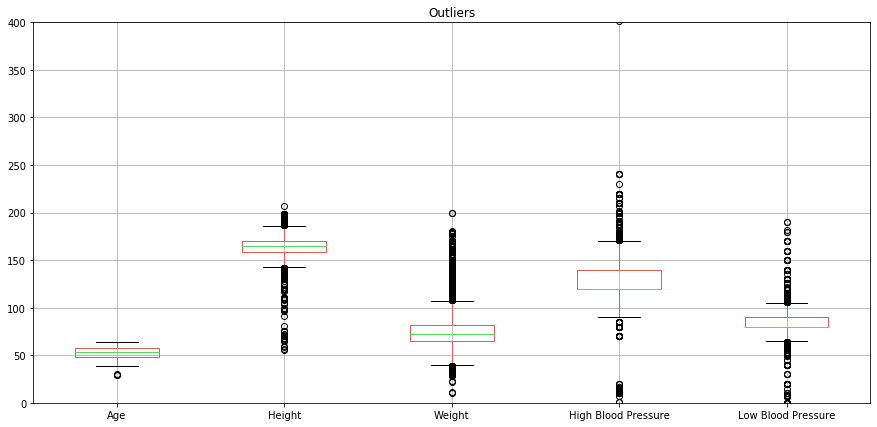

In [148]:
outlier_test = test[['Age','Height','Weight','High Blood Pressure','Low Blood Pressure']]

plt.figure(figsize = (15,7))
a = outlier.boxplot()
a.set_ylim(0,400)
plt.title('Outliers')
plt.show()

**Calculating outlier boundaries**

In [149]:
t_limit = pd.DataFrame(index=['t_Lower','t_Upper'])

for i in ['High Blood Pressure','Low Blood Pressure','Height','Weight']:
    IQR = test[i].quantile(0.75) - test[i].quantile(0.25)
    t_Lower = test[i].quantile(0.25) - (IQR * 3)
    t_Upper = test[i].quantile(0.75) + (IQR * 3)
    t_limit[i]= [t_Lower,t_Upper]
    print('{} outliers are values < {} or > {}'.format(i,t_Lower,t_Upper))
t_limit

High Blood Pressure outliers are values < 60.0 or > 200.0
Low Blood Pressure outliers are values < 50.0 or > 120.0
Height outliers are values < 126.0 or > 203.0
Weight outliers are values < 14.0 or > 133.0


,High Blood Pressure,Low Blood Pressure,Height,Weight
t_Lower,60.0,50.0,126.0,14.0
t_Upper,200.0,120.0,203.0,133.0


**Winsorizing outliers**

In [150]:
test['High Blood Pressure'] = max_(test,'High Blood Pressure',200)
test['Low Blood Pressure'] = max_(test,'Low Blood Pressure',120)
test['Height'] = max_(test,'Height',203)
test['Weight'] = max_(test,'Weight',133)
test['High Blood Pressure'] = min_(test,'High Blood Pressure',60)
test['Low Blood Pressure'] = min_(test,'Low Blood Pressure',50)
test['Height'] = min_(test,'Height',126)
test['Weight'] = min_(test,'Weight',14)

**Label encoding categorical variables**

In [151]:
test.replace({'Gender':{'female':0,'male':1}},inplace=True)
test.replace({'Cholesterol':{'normal':0,'high':1,'too high':2}},inplace=True)
test.replace({'Glucose':{'normal':0,'high':1,'too high':2}},inplace=True) 

**Adding a new feature BMI**

In [152]:
test.insert(4,'BMI', round(test['Weight']/((test['Height']/100)**2),1))

**head of final test data**

In [153]:
test.head()

,Age,Gender,Height,Weight,BMI,High Blood Pressure,Low Blood Pressure,Cholesterol,Glucose,Smoke,Alcohol,Exercise
0,44,0,160,59.0,23.0,100,80,1,0,0,0,1
1,41,0,169,74.0,25.9,120,70,0,0,0,0,1
2,63,1,168,84.0,29.8,120,80,0,1,0,0,1
3,55,0,158,108.0,43.3,160,100,0,0,0,0,0
4,55,0,167,67.0,24.0,120,80,0,0,0,0,1


## Prediction on test data

**Scaling test data for distance based algorithms**

In [154]:
scaled_test = StandardScaler().fit_transform(test)

**Decision Tree**

In [155]:
test_dt = dt_tuned.predict(test)

In [157]:
test_lg = lg_tuned.predict(scaled_test)

In [159]:
test_ANN0 = np.array([x[0] for x in ANN0_tuned.predict(scaled_test)])

In [161]:
test_ANN1 = np.array([x[0] for x in ANN1_tuned.predict(scaled_test)])

In [163]:
test_ANN2 = np.array([x[0] for x in ANN2_tuned.predict(scaled_test)])

**Making a final csv file**

In [165]:
final = pd.DataFrame(list(zip(main['ID'],test_dt,test_lg,test_ANN0,test_ANN1,test_ANN2)),columns=['ID','DT','LR','ANN0','ANN1','ANN2'])

In [166]:
final.head()

,ID,DT,LR,ANN0,ANN1,ANN2
0,0,0,0,0,0,0
1,1,0,0,0,0,0
2,2,1,1,1,0,0
3,3,1,1,1,1,1
4,4,0,0,0,0,0


In [167]:
final.to_csv('final.csv',index=False)

### CONCLUSION

*From all the models that we have built and tuned, we learnt the importance of tuning the model parameters and the way it affects the performance of the model. Hyperparameter is an important part of building a machine learning model. Random Forest, Gradient Boosting Machine models and Non-Linear SVM,in order,produced best results and performed better than rest of the models.*